In [318]:
from astropy import units as u
from astropy.constants import codata2018 as const
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

# Instrument: telescope size

Limitation: diffraction limit $\implies$ telescope radius. From Currie 2023, equation (1)

$$\theta\left({ }^{\prime \prime}\right)_{\mathrm{FWHM}} \sim 0.21\left(\frac{\lambda(\mu m)}{D_{\text {tel }}(m)}\right)$$

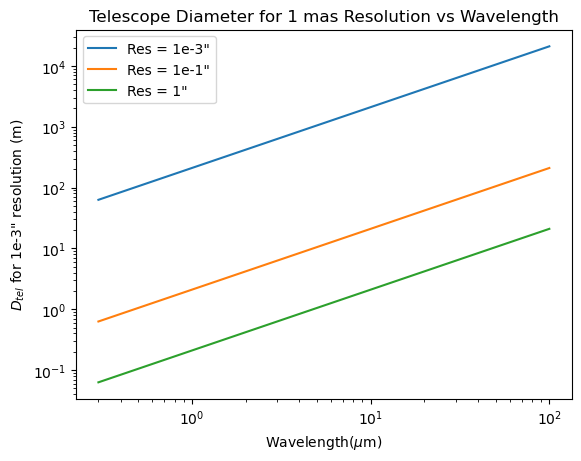

In [763]:
lam = np.linspace(0.3, 100, 3000) # wavelength from visible to mid-IR 
th = 0.001 # angluar resolution in arcseconds
dtel = 0.21*lam/th # telescope diameter in meters
plt.loglog(lam, dtel, label = "Res = 1e-3\"")
plt.loglog(lam, dtel/100, label = "Res = 1e-1\"")
plt.loglog(lam, dtel/1000, label = "Res = 1\"")
plt.xlabel("Wavelength($\\mu\\text{m}$)")
plt.ylabel("$D_{tel}$ for 1e-3\" resolution (m)")
plt.title("Telescope Diameter for 1 mas Resolution vs Wavelength")
plt.legend()
plt.show()

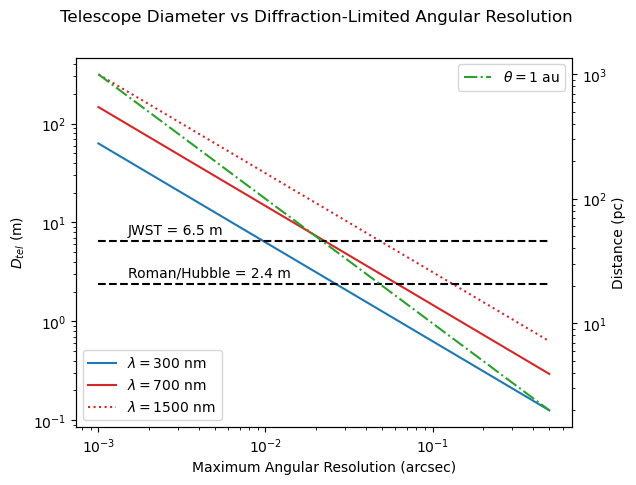

In [301]:
lam7 = 0.7
lam3 = 0.3
lam15 = 1.5
th = np.linspace(0.001, 0.5, 100)
dtel3 = 0.21*lam3/th
dtel7 = 0.21*lam7/th
dtel15 = 0.21*lam15/th
fig, ax1 = plt.subplots()
ax1.plot(th, dtel3, color="tab:blue", label= "$\\lambda = 300$ nm")
ax1.plot(th, dtel7, color="tab:red", label = "$\\lambda = 700$ nm")
ax1.plot(th, dtel15, color="tab:red", ls=":", label = "$\\lambda = 1500$ nm")

ax1.hlines(y = [2.4, 6.5] , xmin = 0.001, xmax = 0.5, ls="--", color="k")
ax1.text(0.0015, 7.5, "JWST = 6.5 m")
ax1.text(0.0015, 2.8, "Roman/Hubble = 2.4 m")

ax1.set_xlabel("Maximum Angular Resolution (arcsec)")
ax1.set_ylabel("$D_{tel}$ (m)")

pc = 206265.0 # pc->au
OneAuAtDistance = 180*3600/(np.pi * th * pc)
ptOneAu = OneAuAtDistance /10
tenAu = OneAuAtDistance * 10
ax2 = ax1.twinx()
ax2.plot(th, OneAuAtDistance, color="tab:green", ls="-.", label="$\\theta = 1$ au")
# ax2.fill_between(th, ptOneAu, tenAu, color = "tab:gray", alpha=0.1)

ax2.set_ylabel("Distance (pc)")
ax2.legend()

ax1.set_yscale("log")
ax1.set_xscale("log")
ax2.set_yscale("log")

fig.suptitle("Telescope Diameter vs Diffraction-Limited Angular Resolution")
ax1.legend(loc="lower left")
fig.savefig("diameter_vs_res.png")
plt.show()

# Instrument: Angular Resolution

Looking at planets with orbital period >200 days. Use Kepler's 3rd law ($T^2 \propto a^3$) with Earth as a baseline to determine a reasonable orbital separation:

In [25]:
t_earth  = 365.25 #days
t_target = 200.0 #days
a_earth  = 1.0 #au
a_target = a_earth*(t_target/t_earth)**(2/3)
print("A planet with an orbital period of {} days will have a SMA of {:.2f} au.".format(t_target, a_target))

A planet with an orbital period of 200.0 days will have a SMA of 0.67 au.


At 20 parsecs, 0.5 au subtends an angle of

In [811]:
angular_res = 0.5*u.au/(20*u.pc)
angular_res = angular_res.to(u.dimensionless_unscaled).value
print("{} mas".format(angular_res * (180/np.pi) * 3600 * 1000))

25.000000000000004 mas


# Instrument: Field of View

Driven by largest orbit to observe in closest system

In [806]:
aLargest = 20*u.au # ~6 au x3
dClosest = 1.3*u.pc
fov = 2*aLargest/dClosest
fov = fov.si # in radians
((fov * 180/np.pi)*60) # sq arc-minutes

<Quantity 0.51282051>

# Observable: Flux

In [560]:
def planckSpectralRadianceVsWavelength(lam, temp):
    """
    Calculates spectral radiance (B_lambda) of a blackbody.

    Args:
        lam (Quantity): Wavelength(s) with units (e.g., 500*u.nm).
        temp (Quantity): Temperature with units (e.g., 5800*u.K).

    Returns:
        float or array: Spectral radiance in SI units (W / (m^2 sr m)).
    """
    l = lam.si.value
    t = temp.si.value
    h = const.h.si.value
    k = const.k_B.si.value
    c = const.c.si.value
    coeff = 2.0 * h * c**2/l**5
    exponent = h * c / (k * t * l)
    out = coeff / np.expm1(exponent)
    return out

In [582]:
def radiantFluxBandpass(temp, lamMin, lamMax):
    """
    Calculates the radiant flux by integrating Planck's Law.
    """
    wavelengths = np.logspace(np.log10(lamMin.si.value), np.log10(lamMax.si.value), 500) * u.m
    integrand = planckSpectralRadianceVsWavelength(wavelengths, temp)
    out = np.pi * integrate.trapezoid(integrand, x=wavelengths.si.value)
    return out

In [584]:
def luminosityBandpass(temp, radius, lamMin, lamMax):
    """
    Calculates the luminosity from the radiant flux and radius.
    """
    M = radiantFluxBandpass(temp, lamMin, lamMax)
    surfaceArea = 4 * np.pi * radius**2
    surfaceArea = surfaceArea.si.value
    L = M * surfaceArea
    return L

In [745]:
def luminositySB(temp, radius):
    """
    Calculates the luminosity of a blackbody using the Stefan Boltzmann law
    """
    sigma = const.sigma_sb.si.value
    out = 4 * np.pi * radius.si.value**2 * sigma * temp.si.value**4
    return out

In [592]:
def blackBodyTemp(incidentFlux, emissivity = 1.0):
    sigma = const.sigma_sb.si.value
    return (incidentFlux/(emissivity*sigma))**0.25

Currie 2023 gives the following definition for contrast:
$$
C_{\mathrm{IR}, \lambda} \sim \frac{F_{\lambda, p}(T, X) r_{\mathrm{p}}^2}{F_{\lambda, s}(T) r_{\mathrm{s}}^2}
$$
Let's figure out what we can see!

In [616]:
# the X-axis will be the orbital period in days
tOrbit = np.linspace(200, 5000)
# use K3L to convert into a distance approximation (in AU)
dOrbit = (tOrbit/365.25)**(2/3)

In [747]:
# the flux of the star assuming size & surface temp similar to the sun
lamMin = 750  * u.nanometer
lamMax = 2500 * u.nanometer
tempStar = 5800 * u.K
rStar = 7e5*u.km
fStar = radiantFluxBandpass(tempStar, lamMin, lamMax)
fStar

27289067.3089739

In [749]:
# double check: actual solar luminosity is ~3.86e26 Watts
radiantFluxBandpass(5800*u.K, 10*u.nanometer, 1e6*u.nanometer) * 4 * np.pi * rStar.si.value**2

3.951556394176124e+26

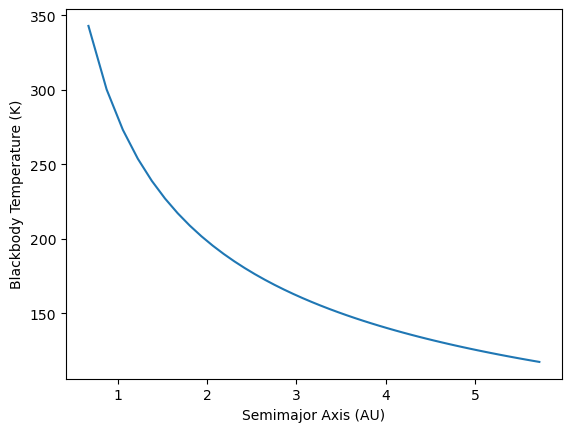

In [751]:
# let's get the black body temp as a function of distance to the star
## use SB law to get total luminosity
lstar = luminositySB(5800*u.K, 7e5*u.km)
# get the distance in SI
dOrbitM = dOrbit * u.au
dOrbitM = dOrbitM.si.value # distance to star in meters
bbTemp = blackBodyTemp(lstar/(16*np.pi*dOrbitM**2))
plt.plot(dOrbit, bbTemp)
plt.xlabel("Semimajor Axis (AU)")
plt.ylabel("Blackbody Temperature (K)")
plt.show()

In [753]:
# get the flux of the planet in the given band based on the BB temp
fPlanet = np.array([radiantFluxBandpass(temp * u.K, lamMin, lamMax) for temp in bbTemp])

In [755]:
# define our radii
rSuperEarth = const.R_earth * 1.5
rSuperEarth = rSuperEarth.si.value
rJup = const.R_jup.si.value

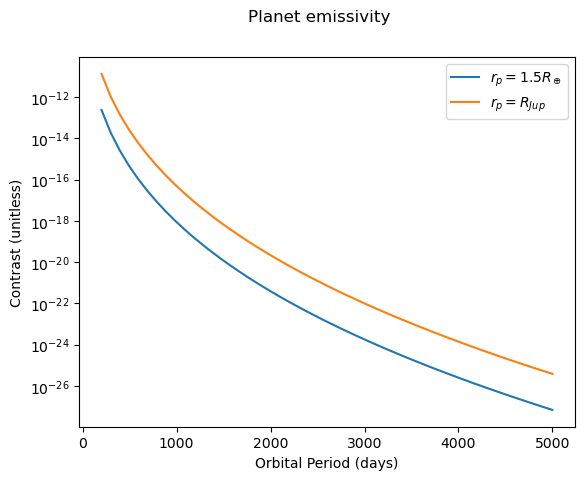

In [757]:
contrastSuperEarth = fPlanet * rSuperEarth**2
contrastSuperEarth = contrastSuperEarth / fStar
contrastSuperEarth = contrastSuperEarth / rStar.si.value**2

contrastJup = fPlanet * rJup**2
contrastJup = contrastJup / fStar
contrastJup = contrastJup / rStar.si.value**2

fig, ax = plt.subplots()
ax.plot(tOrbit, contrastSuperEarth, label = "$r_p = 1.5R_\\oplus$")
ax.plot(tOrbit, contrastJup, label = "$r_p = R_{Jup}$")
ax.set_yscale("log")
ax.set_ylabel("Contrast (unitless)")
ax.set_xlabel("Orbital Period (days)")
ax.legend()
fig.suptitle("Planet emissivity")
plt.show()